In [151]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib
from helpers import *
import matplotlib.pyplot as plt
import random

from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.core.gradients import gradient_table
from dipy.sims.voxel import multi_tensor, multi_tensor_odf
from dipy.data import get_fnames, get_sphere
from dipy.viz import window, actor
from dipy.direction import peaks_from_model
from dipy.reconst.dsi import (DiffusionSpectrumDeconvModel,
                              DiffusionSpectrumModel)

from torch.utils.data import Dataset, DataLoader

In [95]:
#Load the real data
white_mask = nib.load('real_data/white_matter_mask.nii').get_fdata().astype(bool)

hardi_snr10 = nib.load('real_data/DWIS_hardi-scheme_SNR-10.nii').get_fdata()
hardi_snr20 = nib.load('real_data/DWIS_hardi-scheme_SNR-20.nii').get_fdata()
hardi_snr30 = nib.load('real_data/DWIS_hardi-scheme_SNR-30.nii').get_fdata()

hardi_snr10_white_masked = hardi_snr10[white_mask]
hardi_snr20_white_masked = hardi_snr20[white_mask]
hardi_snr30_white_masked = hardi_snr30[white_mask]
hardi_snr10_white_masked *= (100/hardi_snr10_white_masked[0][0])
hardi_snr20_white_masked *= (100/hardi_snr20_white_masked[0][0])
hardi_snr30_white_masked *= (100/hardi_snr30_white_masked[0][0])

gt_peaks = nib.load('real_data/ground-truth-peaks.nii.gz').get_fdata()
gt_white_masked = gt_peaks[white_mask]

In [ ]:
with open('real_data/hardi-scheme.bvec.txt', 'r') as file:
    lines = file.readlines()

real_bvecs = []
for line in lines:
    values = line.split()
    real_bvecs.append([float(value) for value in values])
real_bvecs = np.array(real_bvecs).T


with open('real_data/hardi-scheme.bval.txt', 'r') as file:
    lines = file.readlines()

real_bvals = []
for line in lines:
    values = line.split()
    real_bvals.append([float(value) for value in values])

real_bvals = np.array(real_bvals).reshape(-1)

gtab = gradient_table(real_bvals, real_bvecs)
d_parallel = 0.0015
d_perp = 0.00039
eigenvals = [d_parallel, d_perp, d_perp]

## *Visual sanity check for our approach of mimicking the real data*

Text(0, 0.5, 'Signal Intensity')

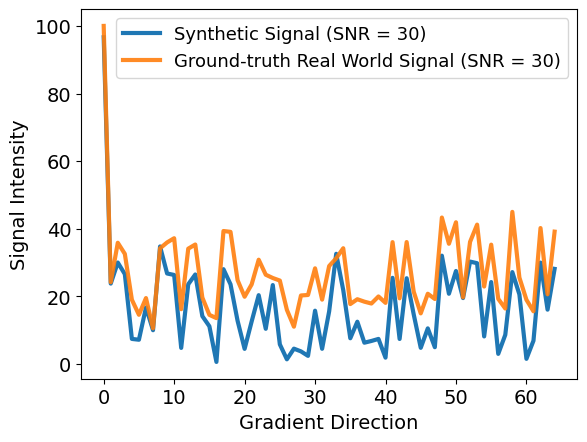

In [86]:
angles, fractions = angles_fractions(gt_white_masked[321])

synthetic_data = multi_tensor(gtab, mevals = [eigenvals]*2, S0=100, angles=angles, fractions=fractions*100,
                               snr=30)[0]

plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.plot(synthetic_data, label = 'Synthetic Signal (SNR = 30)', linewidth=3)
plt.plot(hardi_snr30_white_masked[321], label = 'Ground-truth Real World Signal (SNR = 30)', linewidth=3, alpha=0.9)
plt.legend(fontsize=13)
plt.xlabel('Gradient Direction', fontsize=14)
plt.ylabel('Signal Intensity', fontsize=14)


## *Loading a Pre-Trained Model and Predicting the ODFs*

In [146]:
thetas = list(np.load("synthetic_data/thetas.npy"))
phis = list(np.load("synthetic_data/phis.npy"))
angle_pairs = pd.read_pickle("synthetic_data/angle_pairs.pkl")
hemisphere = HemiSphere(theta=thetas, phi=phis)

In [ ]:
pretrained_model = MatrixFactorizationBatchNormalizationNet_4_layer(65, [512, 256, 128], 180)
pretrained_model.load_state_dict(torch.load('trained_model/models/custom_3_snr_10_to_30_5/ds-6e5_hs-512,256,128_BN-y_loss-SF_lr-0.001.pt',map_location=torch.device('cpu')))

In [ ]:
batch_size = 1024
test_set_hardi = torch.from_numpy(hardi_snr30_white_masked).float()
F_test_set_hardi = torch.from_numpy(np.zeros(hardi_snr30_white_masked.shape[0])).float()
test_dataset_hardi = MatrixDataset(test_set_hardi, F_test_set_hardi)
test_loader_hardi = DataLoader(test_dataset_hardi, batch_size=batch_size, shuffle=False)

In [ ]:
pretrained_model.eval()
with torch.no_grad():
    F_pred_matrix_normalized_list = []
    for S_batch, F_batch in test_loader_hardi:
        S_batch_flattened = S_batch.to_dense().view(S_batch.size(0), -1)
        F_batch_pred = pretrained_model(S_batch_flattened)
        F_batch_pred = apply_sparsity(F_batch_pred, 0.1)
        F_batch_pred_normalized = F_batch_pred / (F_batch_pred.sum(dim=1, keepdim=True)+1e-8)
        
        F_pred_matrix_normalized_list.append(F_batch_pred_normalized)
            
F_pred_np = np.concatenate([tensor.cpu().numpy().flatten() for tensor in F_pred_matrix_normalized_list])
F_pred_np = F_pred_np.reshape((-1,180)).astype(np.double)
        
relative_peak_threshold = 0.1
min_separation_angle = 25
    
predicted_peaks, peak_count, min_peak_count = detect_peaks(F_pred_np, hemisphere, 
        relative_peak_threshold, min_separation_angle)

#Saving the predicted peaks for evaluation
pd.to_pickle(predicted_peaks, "trained_model/peak_results/predicted_peak.pkl")

## *Visualization of one voxel with respect to the ground truth and estimated ODF*

In [167]:
evals = np.tile([0.0015, 0.00039, 0.00039], (len(angle_pairs), 1))

In [180]:
sphere = get_sphere('repulsion724').subdivide(1)

for i in range(15):
    
    random_number = random.randint(0, len(F_pred_np))
    gt_angles, gt_fractions = angles_fractions(gt_white_masked[random_number])
    odf_gt = multi_tensor_odf(sphere.vertices, evals, angles=gt_angles,
                              fractions=gt_fractions)
    
    odf_predicted = multi_tensor_odf(sphere.vertices, evals, angles=angle_pairs,
                              fractions=F_pred_np[random_number])
    
    
    scene = window.Scene()
    
    # concatenate data as 4D array
    odfs = np.vstack((odf_gt, odf_predicted))[:, None, None]
    odf_actor = actor.odf_slicer(odfs, sphere=sphere, scale=0.5, colormap='plasma')
    
    odf_actor.display(y=0)
    odf_actor.RotateX(90)
    scene.add(odf_actor)
    window.record(scene, out_path='comparisons/dsid_comparison_' + str(random_number) + '.png', size=(300, 300))

## *Visualization of the real world data slice*

In [119]:
predicted_peaks_4d = np.zeros((50, 50, 50, 42))
predicted_peaks_4d[white_mask] = predicted_peaks
predicted_peaks_4d = predicted_peaks_4d.reshape(50, 50, 50, 14, 3)

In [100]:
gt_peaks_4d = gt_peaks.reshape(50, 50, 50, 5, 3)

In [136]:
scene = window.Scene()
fodf_peaks = actor.peak_slicer(gt_peaks_4d, mask=white_mask)
scene.add(fodf_peaks)

scene.background((1, 1, 1))

# Save the scene to an image file
window.record(scene, out_path='gt_peaks.png', size=(600, 600))

In [138]:
scene = window.Scene()
fodf_peaks = actor.peak_slicer(predicted_peaks_4d, mask=white_mask)
scene.add(fodf_peaks)

scene.background((1, 1, 1))

window.record(scene, out_path='predicted_peaks.png', size=(600, 600))